In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 12)})
from scipy import stats
from sktime.utils.plotting import plot_correlations
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')

In [63]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Series Temporales - Homework 3 - Modelos VAR y GARCH

### Utilizando datos diarios de yahoo de los dos series (yfinance), debemos analizar la relación entre BMW (BMW.DE) y Volkswagen(VOW.DE)

#### Estima un modelo VAR mensual entre los dos activos. (Muestra: 2009/01 a 2020/10)

##### Tomamos los datos solicitados

In [64]:
bmw_data  =  yf.download('BMW.DE',start="2009-01-01",  end='2021-10-31')
print('Base de datos de BMW')
bmw_data.head()

[*********************100%***********************]  1 of 1 completed
Base de datos de BMW


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,21.620001,22.469999,21.620001,22.340000,14.283447,1830895
2009-01-05,22.559999,22.559999,21.719999,21.855000,13.973351,2226528
2009-01-06,21.900000,22.150000,21.670000,21.775000,13.922203,2756874
2009-01-07,21.625000,22.215000,21.459999,22.040001,14.091638,2313297
2009-01-08,21.905001,22.245001,21.370001,21.900000,14.002124,2468677


In [4]:
vw_data  =  yf.download('VOW.DE', start="2009-01-01",  end='2021-10-31')
print('Base de datos de VW')
vw_data.head()

[*********************100%***********************]  1 of 1 completed
Base de datos de VW


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,252.000000,264.190002,249.979996,259.100006,199.433334,301916
2009-01-05,258.899994,260.489990,251.500000,254.740005,196.077393,295334
2009-01-06,257.000000,301.500000,256.959991,285.000000,219.368988,1058216
2009-01-07,291.000000,301.019989,287.149994,295.000000,227.066116,425027
2009-01-08,290.579987,304.869995,290.410004,298.850006,230.029541,455489


##### Tranformamos datos diarios en datos mensuales, tomando el ultimo valor observado del mes

In [5]:
bmw_data_m = bmw_data['Adj Close'].resample('M').last()
print('Datos mensuales de BMW')
bmw_data_m

Datos mensuales de BMW


Date
2009-01-31    11.898608
2009-02-28    12.627486
2009-03-31    13.931794
2009-04-30    16.783371
2009-05-31    16.435894
                ...    
2021-06-30    89.309998
2021-07-31    83.879997
2021-08-31    80.370003
2021-09-30    82.760002
2021-10-31    87.239998
Freq: M, Name: Adj Close, Length: 154, dtype: float64

In [6]:
vw_data_m = vw_data['Adj Close'].resample('M').last()
print('Datos mensuales de VW')
vw_data_m

Datos mensuales de VW


Date
2009-01-31    192.005600
2009-02-28    144.706589
2009-03-31    178.035233
2009-04-30    185.695969
2009-05-31    165.716019
                 ...    
2021-06-30    272.048065
2021-07-31    280.000000
2021-08-31    283.200012
2021-09-30    268.000000
2021-10-31    280.799988
Freq: M, Name: Adj Close, Length: 154, dtype: float64

##### Tomamos logaritmo neperiano y aplicamos diferencia, para obtener los rendimientos logaritmicos mensuales de los activos

In [7]:
returns_bmw = np.log(bmw_data_m).diff().dropna()
returns_vw = np.log(vw_data_m).diff().dropna()

In [8]:
returns = pd.concat([returns_bmw, returns_vw], axis=1)
returns.columns = ['BMW', 'VW']
print('Retornos logaritmicos de las acciones')
returns

Retornos logaritmicos de las acciones


,BMW,VW
Date,,
2009-02-28,0.059454,-0.282816
2009-03-31,0.098298,0.207273
2009-04-30,0.186215,0.042129
2009-05-31,-0.020921,-0.113835
2009-06-30,0.055341,0.121787
...,...,...
2021-06-30,0.029660,-0.052088
2021-07-31,-0.062726,0.028811
2021-08-31,-0.042746,0.011364


##### Separo el ultimo valor observado para compararlo con la estimacion (test) 

In [9]:
returns_test = returns.tail(13)
print('Test')
returns_test

Test


,BMW,VW
Date,,
2020-10-31,-0.054874,-0.077737
2020-11-30,0.218908,0.151795
2020-12-31,-0.011152,0.089741
2021-01-31,-0.031218,0.025538
2021-02-28,0.021059,0.104386
2021-03-31,0.212966,0.467678
2021-04-30,-0.059015,-0.157282
2021-05-31,0.085040,0.098677
2021-06-30,0.029660,-0.052088


In [10]:
returns.drop(returns.tail(13).index,inplace=True)
print('Train')
returns

Train


,BMW,VW
Date,,
2009-02-28,0.059454,-0.282816
2009-03-31,0.098298,0.207273
2009-04-30,0.186215,0.042129
2009-05-31,-0.020921,-0.113835
2009-06-30,0.055341,0.121787
...,...,...
2020-05-31,0.027370,0.043782
2020-06-30,0.077172,0.006300
2020-07-31,-0.038025,-0.076849


##### Test de Causalidad de Granger - Hasta 12 retardos

Es un test consistente en comprobar si los resultados de una variable sirven para predecir a otra variable, si tiene carácter unidireccional o bidireccional. Para ello se tiene que comparar y deducir si el comportamiento actual y el pasado de una serie temporal A predice la conducta de una serie temporal B. Si ocurre el hecho, se dice que “el resultado A” causa en el sentido de Wiener-Granger “el resultado B”; el comportamiento es unidireccional. Si sucede lo explicado e igualmente “el resultado B” predice “el resultado A”, el comportamiento es bidireccional, entonces “el resultado A” causa “el resultado B”, y “el resultado B” causa “el resultado A”.

La hipotesis nula para los test aplicado corresponden a suponer que los coeficientes de los valores pasados de X son 0.

In [11]:
print('BMW -> VW')
grangercausalitytests(returns[['BMW', 'VW']], 12)

BMW -> VW

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2797  , p=0.2599  , df_denom=136, df_num=1
ssr based chi2 test:   chi2=1.3079  , p=0.2528  , df=1
likelihood ratio test: chi2=1.3018  , p=0.2539  , df=1
parameter F test:         F=1.2797  , p=0.2599  , df_denom=136, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8033  , p=0.1688  , df_denom=133, df_num=2
ssr based chi2 test:   chi2=3.7422  , p=0.1540  , df=2
likelihood ratio test: chi2=3.6924  , p=0.1578  , df=2
parameter F test:         F=1.8033  , p=0.1688  , df_denom=133, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3349  , p=0.2659  , df_denom=130, df_num=3
ssr based chi2 test:   chi2=4.2204  , p=0.2386  , df=3
likelihood ratio test: chi2=4.1567  , p=0.2450  , df=3
parameter F test:         F=1.3349  , p=0.2659  , df_denom=130, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0713  , 

{1: ({'ssr_ftest': (1.2797192933512236, 0.25994209233774357, 136.0, 1),
   'ssr_chi2test': (1.3079483954104416, 0.25276644572477075, 1),
   'lrtest': (1.3018330265488203, 0.2538786715183081, 1),
   'params_ftest': (1.279719293351225, 0.25994209233774357, 136.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.803317151782683, 0.16875630112580683, 133.0, 2),
   'ssr_chi2test': (3.7422220593385003, 0.15395252094301917, 2),
   'lrtest': (3.6923811454016686, 0.157837292209673, 2),
   'params_ftest': (1.8033171517826903, 0.16875630112580545, 133.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3349286007668664, 0.2658792862638048, 130.0, 3),
   'ssr_chi2test': (4.22042811473217, 0.23862458532381242, 3),
   'lrtest': (4.156725740614775, 0.2450303289700391, 3),
   'params_ftest': (1.3349286007668688, 0.2658792862638048, 130.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [12]:
print('VW -> BMW')
grangercausalitytests(returns[['VW','BMW']], 12)

VW -> BMW

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2348  , p=0.6287  , df_denom=136, df_num=1
ssr based chi2 test:   chi2=0.2400  , p=0.6242  , df=1
likelihood ratio test: chi2=0.2398  , p=0.6244  , df=1
parameter F test:         F=0.2348  , p=0.6287  , df_denom=136, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6788  , p=0.5090  , df_denom=133, df_num=2
ssr based chi2 test:   chi2=1.4085  , p=0.4945  , df=2
likelihood ratio test: chi2=1.4014  , p=0.4962  , df=2
parameter F test:         F=0.6788  , p=0.5090  , df_denom=133, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1582  , p=0.3283  , df_denom=130, df_num=3
ssr based chi2 test:   chi2=3.6618  , p=0.3004  , df=3
likelihood ratio test: chi2=3.6137  , p=0.3063  , df=3
parameter F test:         F=1.1582  , p=0.3283  , df_denom=130, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0719  , 

{1: ({'ssr_ftest': (0.2348255587440224, 0.6287481443241985, 136.0, 1),
   'ssr_chi2test': (0.2400055343045523, 0.6242021176291895, 1),
   'lrtest': (0.23979856870926142, 0.6243516369051075, 1),
   'params_ftest': (0.2348255587440292, 0.6287481443241985, 136.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.6787555542480627, 0.5089960779170808, 133.0, 2),
   'ssr_chi2test': (1.4085453606952276, 0.494468079854506, 2),
   'lrtest': (1.401405497355995, 0.4962364517176808, 2),
   'params_ftest': (0.6787555542480492, 0.5089960779170808, 133.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1582329125565578, 0.3283375218231503, 130.0, 3),
   'ssr_chi2test': (3.6617979004672714, 0.30037576073658107, 3),
   'lrtest': (3.6137156996527438, 0.3063102903349459, 3),
   'params_ftest': (1.1582329125565538, 0.3283375218231535, 130.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

Dados los resultados, los resultados de BMW modifican a los valores de VW, es decir, los coeficientes de los valores pasados de BMW son distintos de cero a la hora de intentar explicar a la variable VW.

## Aplicación del Modelo VAR

In [13]:
model = VAR(returns)
model.select_order(24)
results = model.fit(maxlags=24, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Nov, 2021
Time:                     14:29:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.77169
Nobs:                     139.000    HQIC:                  -9.84689
Log likelihood:           299.471    FPE:                5.02577e-05
AIC:                     -9.89836    Det(Omega_mle):     4.81566e-05
--------------------------------------------------------------------
Results for equation BMW
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.010182         0.007039            1.447           0.148
L1.BMW         0.065772         0.105543            0.623           0.533
L1.VW         -0.087931         0.077730           -1.131           0.258

Results for equ

#### Obtenemos un modelo VAR(1)

Es decir que solo se contemplan efectos con 1 retardo entre las variables

#### Realizamos la predicción para los próximos periodos para cada serie

In [14]:
lag_order = results.k_ar
prediction = results.forecast(returns.values[-lag_order:], 13)
print('Resultados de nuestra predicción para BMW y VW respectivamente')

Resultados de nuestra predicción para BMW y VW respectivamente


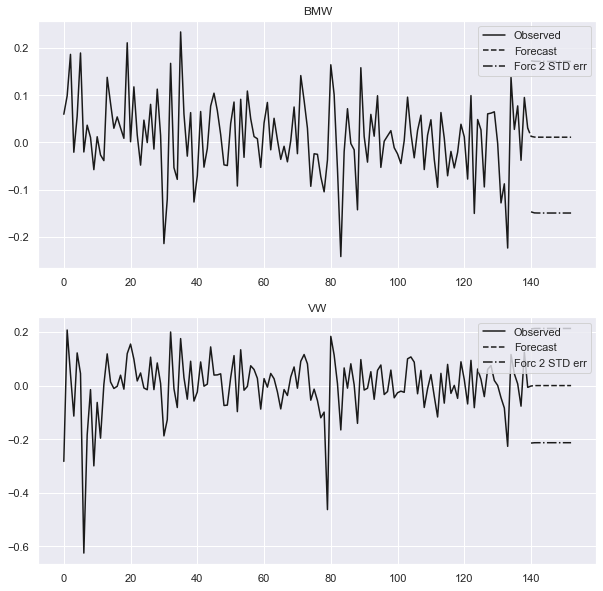

In [15]:
results.plot_forecast(13);

#### Correlaciones de los residuos, ¿Son ruido blanco?

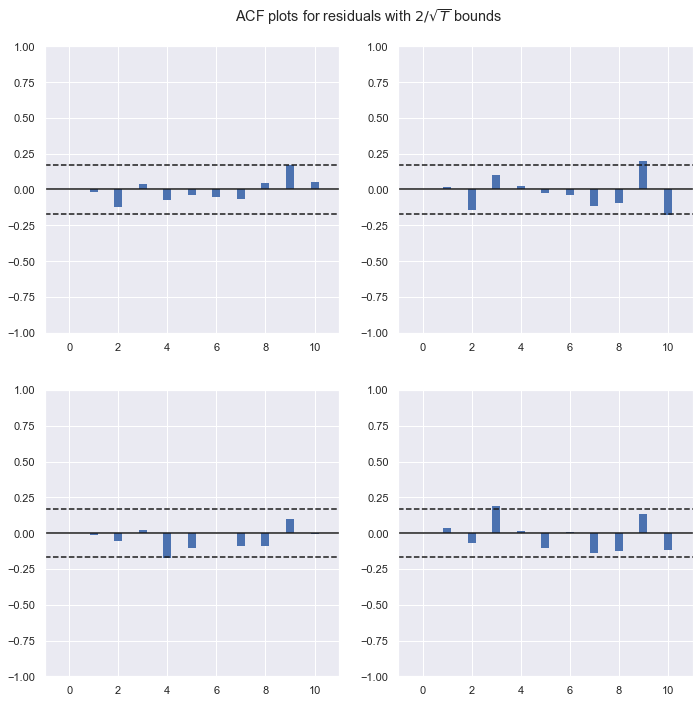

In [16]:
results.plot_acorr();

Podemos decir que si

#### Analizaremos los efectos que sufre una variable ante cambios en las otra variable (función de respuesta al impulso)

##### Se analizan los gráficos en la diagonal contraria a la diagonal principal en este caso

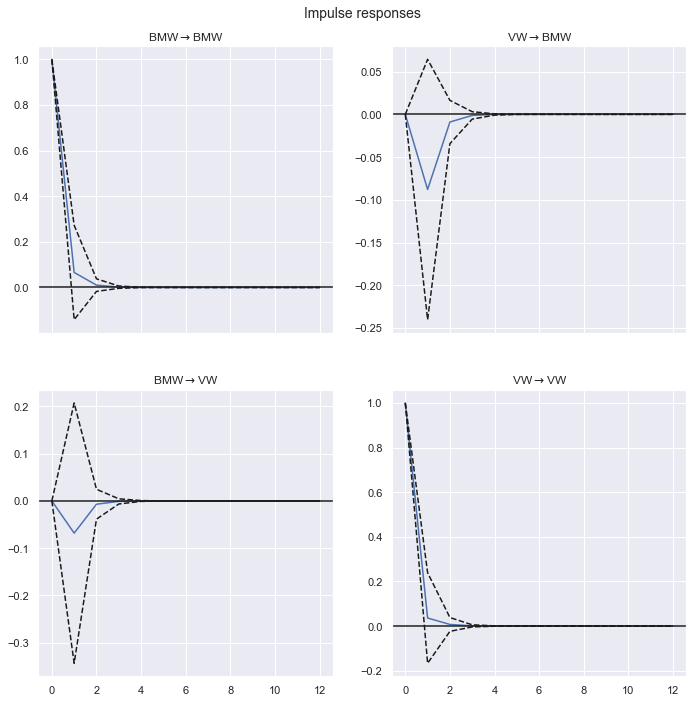

In [17]:
irf = results.irf(12)
irf.plot(orth=False);

##### Como resultado, verificamos que no existen efectos significativos en el tiempo ante cambios de las distintas variables en el tiempo, no hay efecto duradero

#### Función de Respuesta al Impulso ACUMULADA

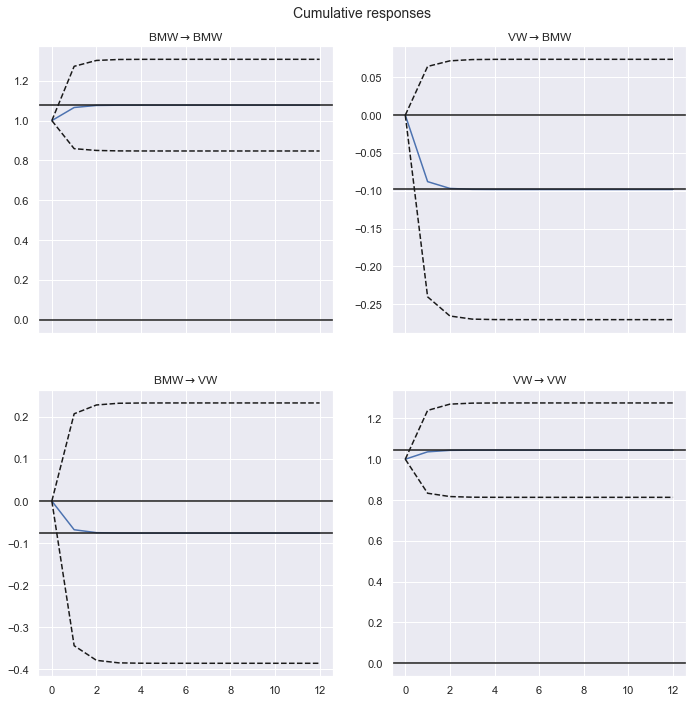

In [18]:
irf.plot_cum_effects(orth=False);

#### Este resultado era esperable ya que los impactos no son significativos en todo el tramo anterior

### Descomposiciñon del error de predicción

In [19]:
fevd = results.fevd(12)
fevd.summary()

FEVD for BMW
           BMW        VW
0     1.000000  0.000000
1     0.991657  0.008343
2     0.991571  0.008429
3     0.991569  0.008431
4     0.991569  0.008431
5     0.991569  0.008431
6     0.991569  0.008431
7     0.991569  0.008431
8     0.991569  0.008431
9     0.991569  0.008431
10    0.991569  0.008431
11    0.991569  0.008431

FEVD for VW
           BMW        VW
0     0.386668  0.613332
1     0.386862  0.613138
2     0.386850  0.613150
3     0.386850  0.613150
4     0.386850  0.613150
5     0.386850  0.613150
6     0.386850  0.613150
7     0.386850  0.613150
8     0.386850  0.613150
9     0.386850  0.613150
10    0.386850  0.613150
11    0.386850  0.613150




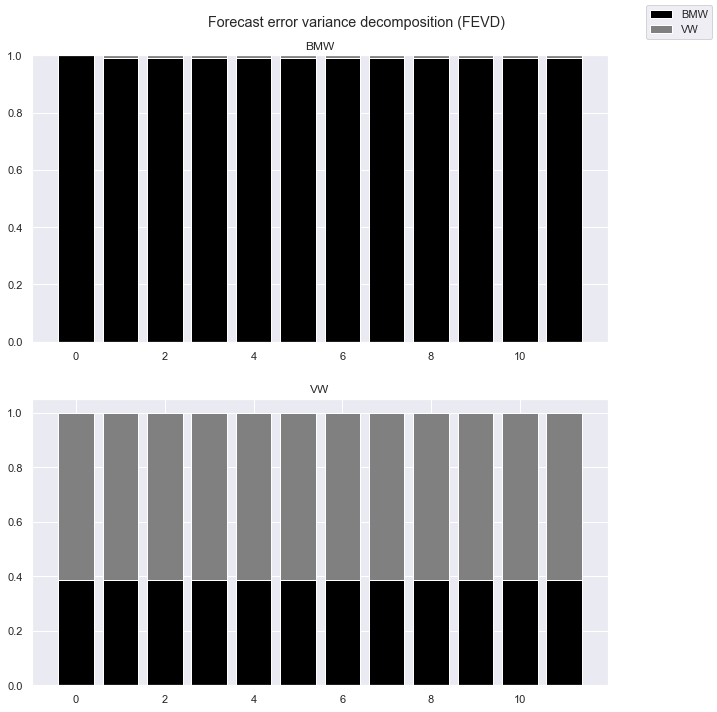

In [20]:
results.fevd(12).plot();

Los errores de VW se explican en un  40% debido a los errores de BMW. Mientras que los errores de BMW se explican por sí solos.

Estos resultados y considerando los resultados de las pruebas de causalidad de Granger, podemos definir a BMW como la empresa lider y a VW como la empresa seguidora.

### Análisis de Causalidad de Granger

In [21]:
results.test_causality('BMW', 'VW', kind='f').summary()

Test statistic,Critical value,p-value,df
1.280,3.876,0.259,"(1, 272)"


Vemos que no es estadisticamente significativa la influencia de BMW sobre VW

### Normalidad

In [22]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
2438.,9.488,0.000,4


## Comparación de la estimación entre el precio real y el estimado

In [23]:
prediction_df = pd.DataFrame(prediction, columns=returns.columns)
prediction_df['Date'] = pd.date_range('2020-10-31', periods=13, freq='M')
prediction_df.set_index(['Date'], inplace=True)


In [24]:
prediction_df_exp = np.exp(prediction_df) - 1 

In [25]:
prices_df = pd.concat([bmw_data_m, vw_data_m], axis=1)
prices_df.columns = ['BMW', 'VW']

In [26]:
prices_forecasted = pd.DataFrame([])

prices_forecasted['BMW'] = prediction_df_exp['BMW'].cumsum()
prices_forecasted['VW'] = prediction_df_exp['VW'].cumsum()

prices_forecasted['BMW'] = prices_df.BMW.loc['2020-09-30'] * (1 + prediction_df_exp['BMW'])
prices_forecasted['VW'] = prices_df.VW.loc['2020-09-30'] * (1 + prediction_df_exp['VW'])

In [27]:
prices_forecasted

,BMW,VW
Date,,
2020-10-31,59.948772,141.696169
2020-11-30,59.853464,141.890161
2020-12-31,59.840001,141.912558
2021-01-31,59.838285,141.915542
2021-02-28,59.838062,141.915927
2021-03-31,59.838033,141.915977
2021-04-30,59.838029,141.915983
2021-05-31,59.838029,141.915984
2021-06-30,59.838029,141.915984


(array([-3.,  0.,  3.,  6.,  9., 12., 15., 18., 21., 24.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

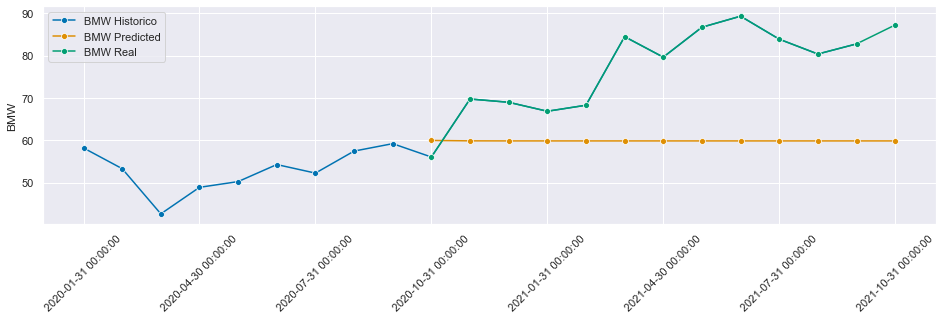

In [28]:
plot_series(prices_df.loc['01-01-2020':].drop(prices_df.tail(1).index).BMW, prices_forecasted.BMW, bmw_data_m[returns_test.index], labels=['BMW Historico', 'BMW Predicted', 'BMW Real'])
plt.xticks(rotation=45)
#text = fig.text(0.5, 0.96, "$y=sin(x)$")
#text.remove()

(array([-3.,  0.,  3.,  6.,  9., 12., 15., 18., 21., 24.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

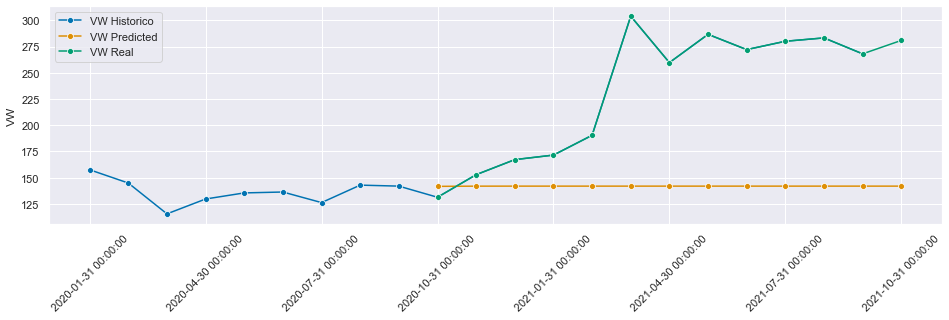

In [29]:
plot_series(prices_df.loc['01-01-2020':].drop(prices_df.tail(1).index).VW, prices_forecasted.VW, vw_data_m[returns_test.index], labels=['VW Historico', 'VW Predicted', 'VW Real'])
plt.xticks(rotation=45)
#text = fig.text(0.5, 0.96, "$y=sin(x)$")
#text.remove()

# ¿Cuál es la predicción para octubre de 2021 de los dos activos?. ¿Son buenas predicciones?

Si bien para el período de 10-2020 vemos una sobre estimación en ambos activos, en el resto de los períodos dado a lo constante que son estas predicciones, terminamos subvaluando los precios futuros. Esto nos determina que no son estimaciones confiables.

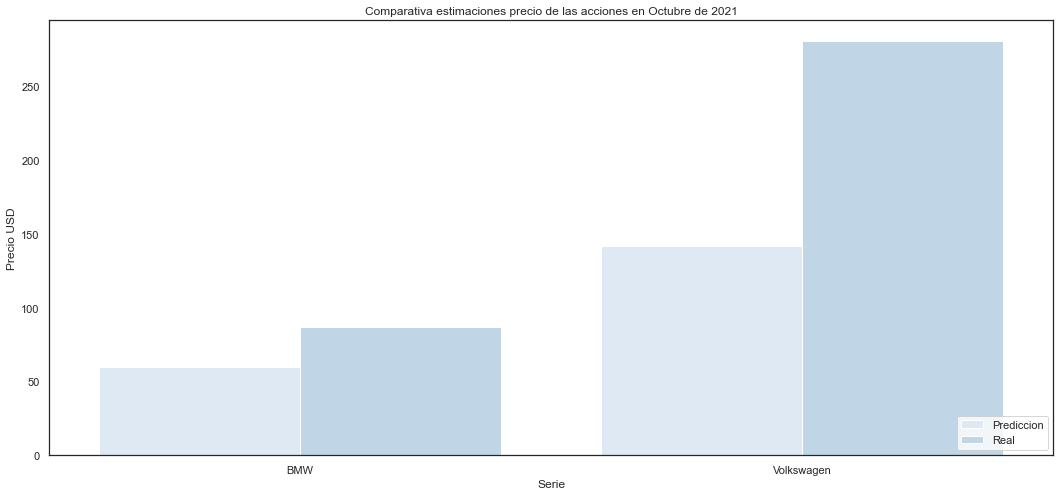

In [30]:
sns.set(rc={'figure.figsize':(18, 8)})
# Creamos un data frame auxiliar para representar conjuntamente las dos predicciones
data = {'Serie' : ['BMW', 'Volkswagen', 'Volkswagen', 'BMW'],
         'Estimacion': ['Prediccion', 'Prediccion', 'Real', 'Real'],
         'Ingresos' : [prices_forecasted.BMW.loc['31-10-2021'], prices_forecasted.VW.loc['31-10-2021'],
                       vw_data_m[returns_test.index].loc['31-10-2021'], bmw_data_m[returns_test.index].loc['31-10-2021']]}

comp_pred_df = pd.DataFrame(data)
comp_pred_df

sns.set_palette('Blues')
sns.set_style('white')
ax = sns.barplot(x=comp_pred_df.Serie, y='Ingresos', hue='Estimacion', data = comp_pred_df)

#for container in ax.containers:
#    ax.bar_label(container, color='black', padding=-20)

ax.legend(loc='lower right')
ax.set_ylabel('Precio USD')
ax.set_title('Comparativa estimaciones precio de las acciones en Octubre de 2021');

In [31]:
sns.set(rc={'figure.figsize':(16, 12)})

# Modelo GARCH

## Volatilidad BMW


##### Tomamos los datos historicos hasta el 31/10/2021 para realizar nuestra predicción

In [32]:
bmw_data  =  yf.download('BMW.DE',  end='2020-10-31')
bmw_data = bmw_data[['Adj Close']]#.resample('M').last()
print('Datos de cotizaciones de BMW')
bmw_data

[*********************100%***********************]  1 of 1 completed
Datos de cotizaciones de BMW


,Adj Close
Date,
1996-11-08,10.041773
1996-11-11,10.014694
1996-11-12,10.090404
1996-11-13,10.074375
1996-11-14,10.106983
...,...
2020-10-26,60.354069
2020-10-27,58.692688
2020-10-28,55.436756


##### Graficamos

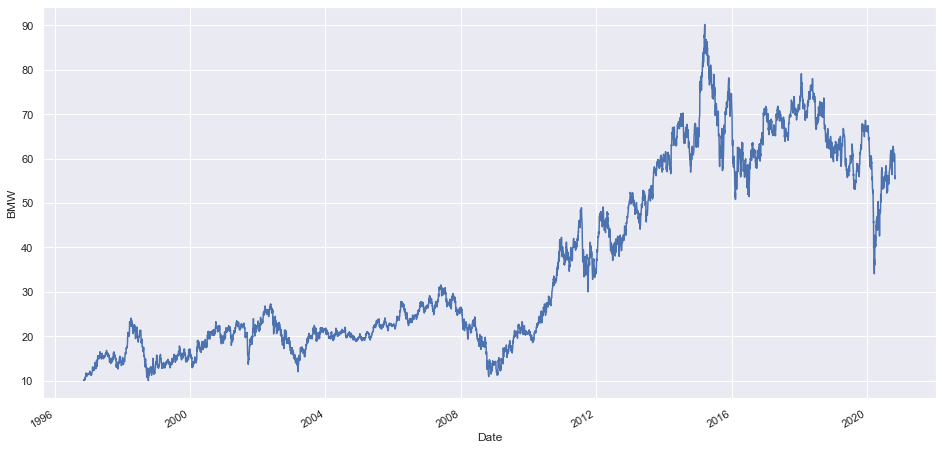

In [33]:
sns.set(rc={'figure.figsize':(16, 8)})
ax = bmw_data["Adj Close"].plot( linestyle='-')
ax.set_ylabel('BMW');

##### Tomamos logaritmo neperiano y diferencias para poder trabajar con los rendimientos

In [34]:
bmw_data['log_ret'] = np.log(bmw_data).diff().dropna()
bmw_data.tail()

,Adj Close,log_ret
Date,,
2020-10-26,60.354069,-0.011326
2020-10-27,58.692688,-0.027913
2020-10-28,55.436756,-0.057072
2020-10-29,55.694557,0.004640
2020-10-30,56.028740,0.005982


##### Calculamos el cuadrado de los rendimientos para obtener una proxy de la volatilidad observada

In [35]:
bmw_data['Squared'] = bmw_data['log_ret']**2
bmw_data.tail()

,Adj Close,log_ret,Squared
Date,,,
2020-10-26,60.354069,-0.011326,0.000128
2020-10-27,58.692688,-0.027913,0.000779
2020-10-28,55.436756,-0.057072,0.003257
2020-10-29,55.694557,0.004640,0.000022
2020-10-30,56.028740,0.005982,0.000036


#### Graficamos los valores calculados previamente

Text(0.5, 0.8, 'Volatilidad')

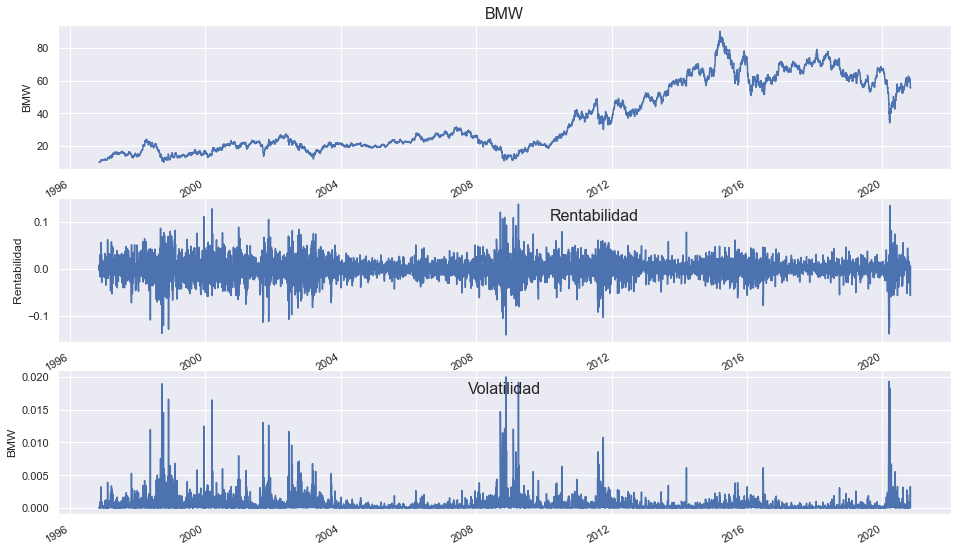

In [36]:
fig = plt.figure(figsize=(16,10))
plt.subplot(311)
ax=bmw_data["Adj Close"].plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)
plt.subplot(312)
ax=bmw_data.log_ret.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16)
plt.subplot(313)
ax=bmw_data.Squared.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, fontsize = 16)

#### Verificamos que los rendimientos sean estacionarios en media

In [37]:
alpha=0.05
t, p =stats.ttest_1samp(bmw_data['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 1.0061952312339149
p-value: 0.31436126475853904
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


##### Tomamos la volatilidad y la graficamos junto con los terminos de autocorrelacion

In [38]:
# Create proxy Volatility 
bmw_vol=bmw_data['Squared'].astype('float64').to_period('D').sort_index().dropna()
print('Volatilidad de BMW')
bmw_vol.tail()

Volatilidad de BMW


Date
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared, dtype: float64

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

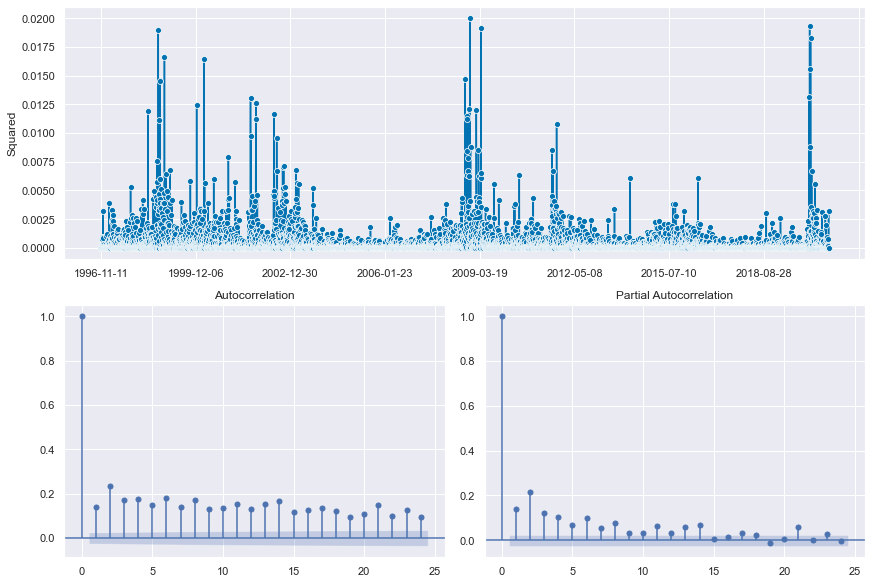

In [39]:
# Plot Autocorrelation
plot_correlations(bmw_vol)

In [40]:
test_Ljung_Box=sm.stats.acorr_ljungbox

##### Generamos el test de Ljung-Box para verificar si se trata de ruido blanco

In [41]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(bmw_vol, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,1672.971249,0.0
20,2759.139952,0.0
30,3516.358140,0.0


Esto nos permite generar un modelo GARCH

##### Generamos un test  para verificar si existe Heterocedasticidad Condicional Autorregresiva (ARCH)

In [42]:
test_LM_ARCH= sm.stats.diagnostic.het_arch
# testing LM-ARCH
# pvalue < alpha -> ARCH
lm, lmpval, f, pval, result_int =test_LM_ARCH(bmw_data['log_ret'].dropna(), nlags=52, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  857.4042156273237
p-value:  2.859652903897774e-146
Estadístico F:  19.01993123616497
p-value:  4.833496387042917e-159


##### No podemos rechazar la hipotesis nula

## Gereneramos un modelo GARCH(1,1)

#### Generamos un modelo para la media

In [43]:
ar = ARX(100*bmw_data['log_ret'].dropna(), lags=[1])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:               -13509.9
Distribution:                  Normal   AIC:                           27025.8
Method:            Maximum Likelihood   BIC:                           27045.9
                                        No. Observations:                 6148
Date:                Fri, Nov 26 2021   Df Residuals:                     6146
Time:                        14:29:18   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0274  2.780e-02      0.984      0.325 

#### Luego generamos un modelo GARCH para la varianza

In [44]:
ar.volatility = GARCH(p=1,q=1)
res_n = ar.fit(update_freq=0, disp="off")
print(res_n.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12605.2
Distribution:                  Normal   AIC:                           25220.5
Method:            Maximum Likelihood   BIC:                           25254.1
                                        No. Observations:                 6148
Date:                Fri, Nov 26 2021   Df Residuals:                     6146
Time:                        14:29:18   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const          0.0526  2.108e-02      2.496  1.258e-02 [1.

##### Graficamos los residuos y la volatilidad condicional anualizada

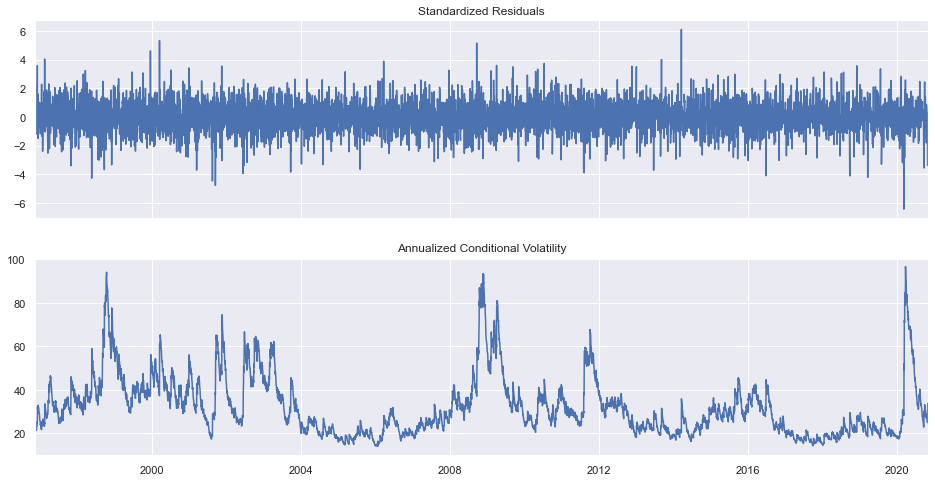

In [45]:
fig = res_n.plot(annualize="D")

##### Graficamos los residuos y los componentes de autocorrelacion

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

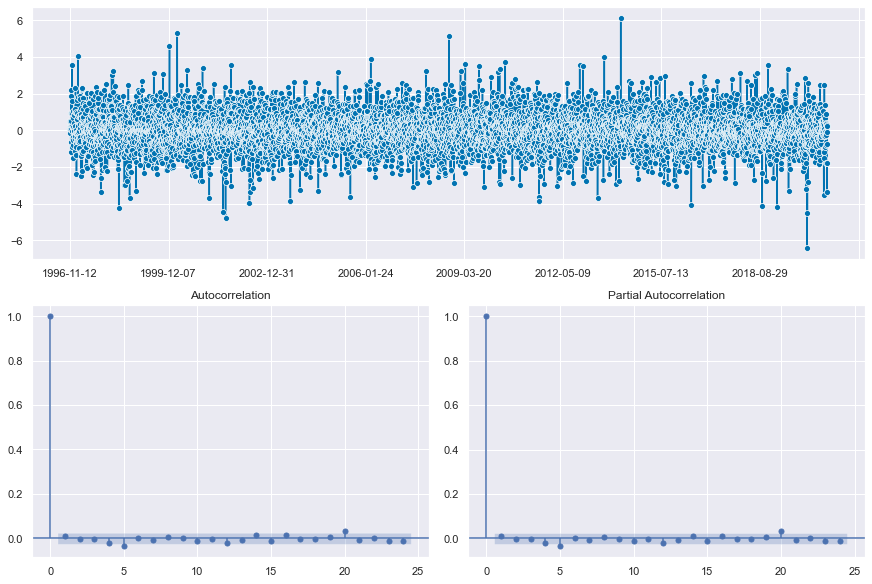

In [46]:
# Análisis Residuos
mod1_std_resid=(res_n.resid / res_n.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

##### Lo mismo pero en este caso para la varianza

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

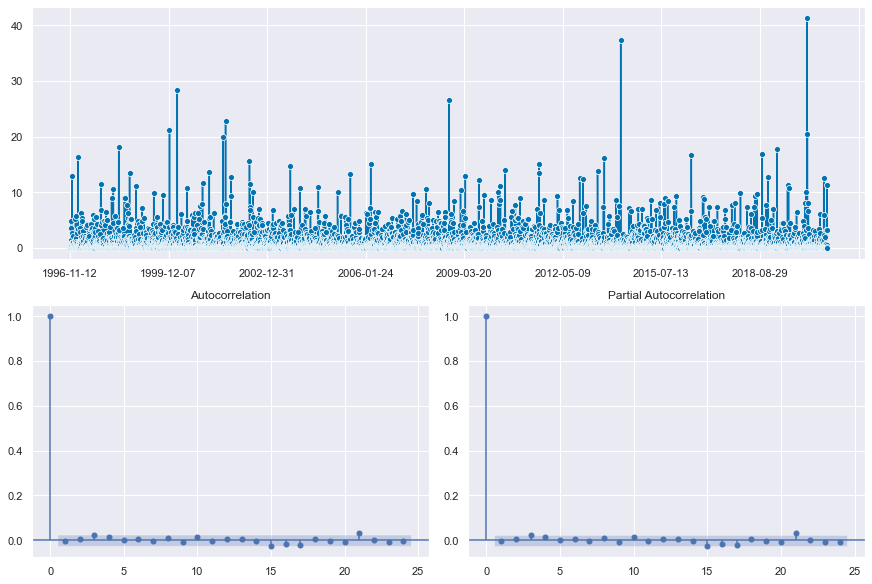

In [47]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

##### Verificamos que se trate de ruido blanco

In [48]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,7.644358,0.663530
20,16.477167,0.686615
30,27.876272,0.576993


#### Se trata de ruido blanco

#### Ahora el siguiente paso es verificar que los residuos se asemejen a una distribucion normal, este proceso lo realizamos comparando los puntos sobre la diagonal trazada. Si los puntos se alejan de dicha diagonal, no estamos ante una distribución normal 

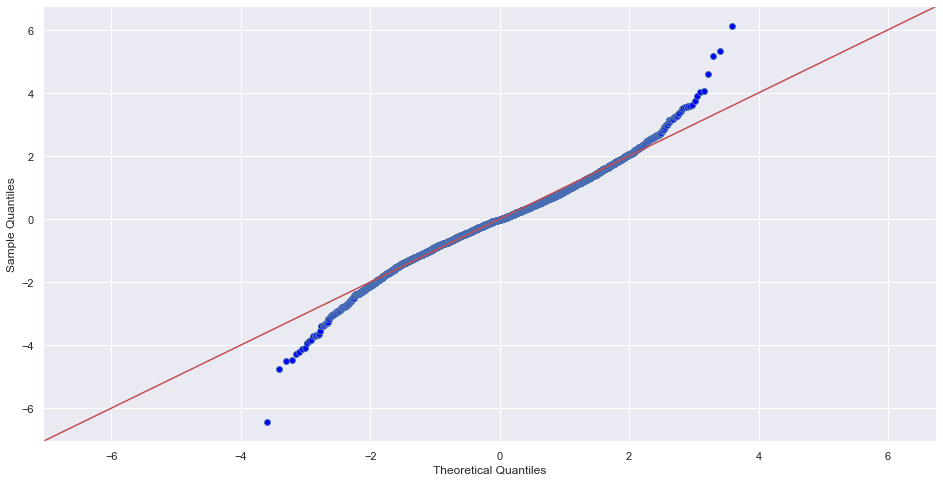

In [49]:
# qqplot
sm.qqplot(mod1_std_resid,line='45')
plt.show()

#### Como las colas de la serie estan muy fuera de la diagonal, vamos a replicar el modelo pero en este caso bajo una distribución T de Student

In [50]:
#GARCH(1,1) + t-student

from arch.univariate import StudentsT

In [51]:
ar.distribution = StudentsT()
res_t = ar.fit(update_freq=0, disp="off")
print(res_t.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12454.7
Distribution:      Standardized Student's t   AIC:                           24921.4
Method:                  Maximum Likelihood   BIC:                           24961.8
                                              No. Observations:                 6148
Date:                      Fri, Nov 26 2021   Df Residuals:                     6146
Time:                              14:29:21   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

#### Graficamos los residuos estandarizados

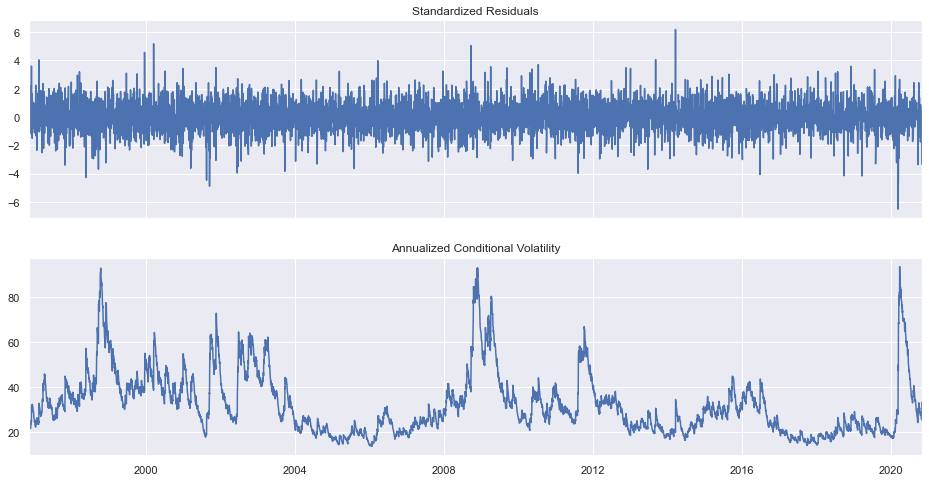

In [52]:
fig = res_t.plot(annualize="D")

#### Analizamos la autocorrelación de los residuos

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

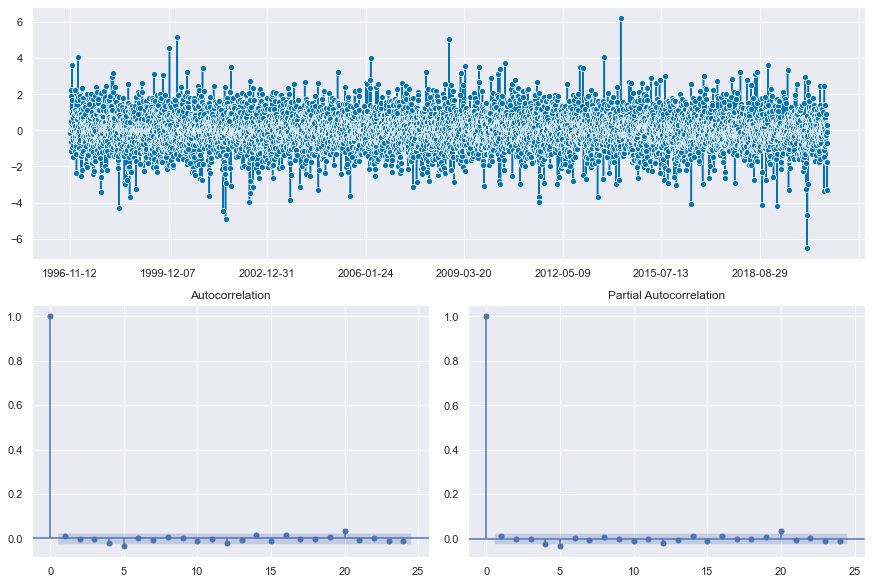

In [53]:
# Análisis Residuos
mod1_std_resid=(res_t.resid / res_t.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

#### Tomando los residuos cuadrados

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

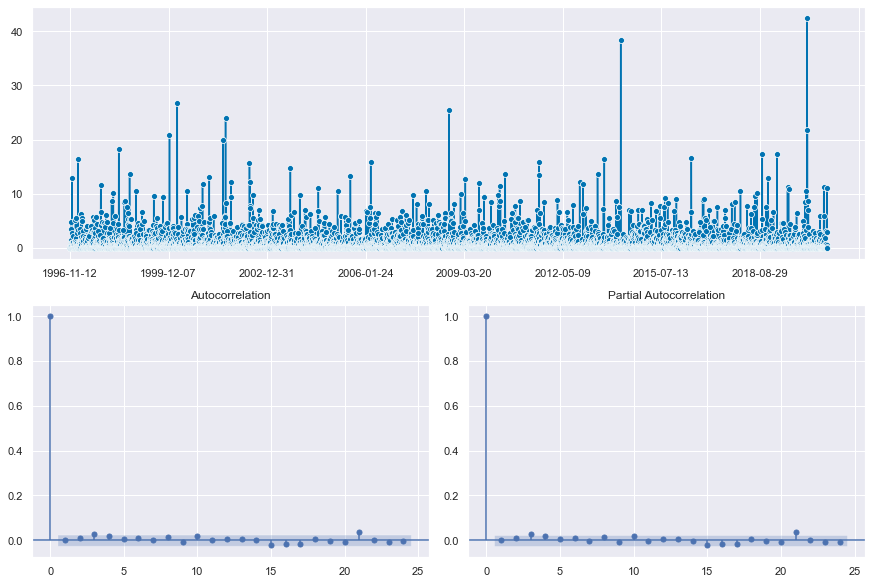

In [54]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

#### Realizamos el test para verificar si se trata de ruido blanco

In [55]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,12.393527,0.259582
20,20.607045,0.420577
30,32.606465,0.339872


#### Se trata de ruido blanco

#### Ahora el siguiente paso es verificar que los residuos se asemejen a una distribucion T de Student, este proceso lo realizamos comparando los puntos sobre la diagonal trazada. Si los puntos se alejan de dicha diagonal, no estamos ante una distribución T de Student 

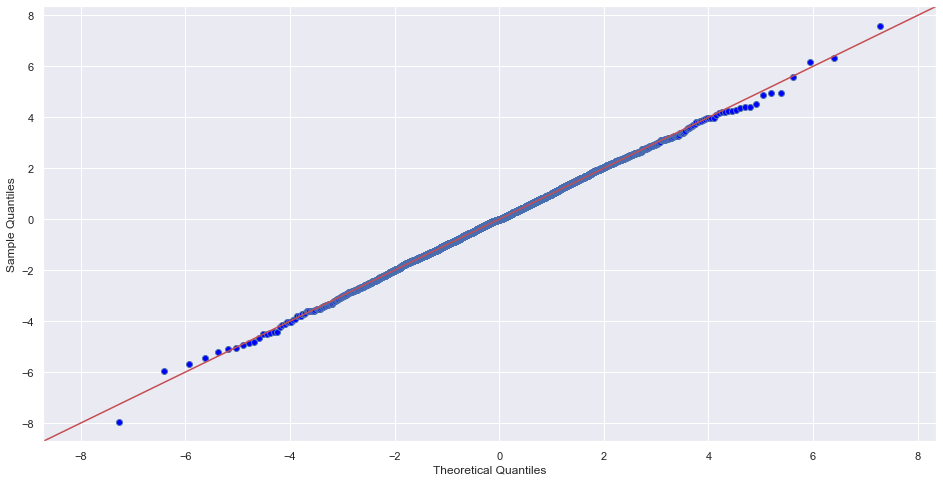

In [56]:
# qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

#### Estamos ante una distribución T de Student, podemos pasar a predecir los precios

In [57]:
# Forecast Volatility Predicción 21 días
forecasts = res_t.forecast(horizon=21, reindex=False)
# Mean
forecast_mean = forecasts.mean.T
forecast_mean['Date'] = pd.bdate_range('2020-11-01', '2020-11-30')
forecast_mean.set_index(['Date'], inplace=True)
forecast_mean.columns = ['Media']


In [58]:
# Varianza
forecast_variance = (forecasts.variance**0.5)*np.sqrt(252)
forecast_variance = forecast_variance.T.reset_index(drop=True)
forecast_variance['Date'] = pd.bdate_range('2020-11-01', '2020-11-30')
forecast_variance.set_index(['Date'], inplace=True)
forecast_variance.columns = ['Varianza']


In [59]:
estimacion = pd.concat([forecast_mean, forecast_variance], axis=1)
print('Predicciones para las Variaciones de precio de BMW para el proximo mes')
estimacion

Predicciones para las Variaciones de precio de BMW para el proximo mes


,Media,Varianza
Date,,
2020-11-02,0.058453,31.771630
2020-11-03,0.037142,31.837352
2020-11-04,0.036301,31.878300
2020-11-05,0.036267,31.919087
2020-11-06,0.036266,31.959751
2020-11-09,0.036266,32.000294
2020-11-10,0.036266,32.040715
2020-11-11,0.036266,32.081016
2020-11-12,0.036266,32.121197


In [60]:
price_bmw = bmw_data.iloc[-1, 0]


In [61]:
bmw_GARCH_prices = (np.exp(np.cumsum(forecasts.mean))*price_bmw)
bmw_GARCH_prices
forecast_prices = bmw_GARCH_prices.T.reset_index(drop=True)
forecast_prices['Date'] = pd.bdate_range('2020-11-01', '2020-11-30')
forecast_prices.set_index(['Date'], inplace = True)
forecast_prices.columns = ['BMW']
print('Predicciones para los precios de BMW para el proximo mes')
forecast_prices

Predicciones para los precios de BMW para el proximo mes


,BMW
Date,
2020-11-02,59.401414
2020-11-03,58.148891
2020-11-04,58.099986
2020-11-05,58.098056
2020-11-06,58.097979
2020-11-09,58.097976
2020-11-10,58.097976
2020-11-11,58.097976
2020-11-12,58.097976


## Proyección de BMW mediante modelo GARCH(1,1)

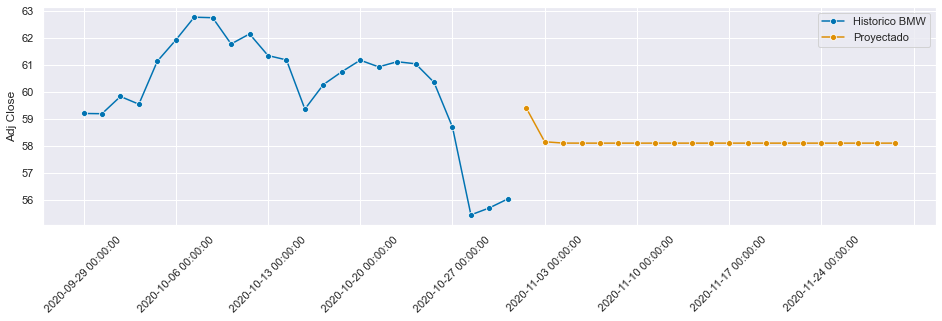

In [62]:
plot_series(bmw_data["Adj Close"].tail(24), forecast_prices, , labels=['Historico BMW', 'Proyectado'])
plt.xticks(rotation=45)
text = fig.text(0.5, 0.96, "$y=sin(x)$")
text.remove()

## ¿Es la Volatilidad de BMW constante? 

Luego de los primeros dos períodos que son diferentes a las proyecciones futuras, podemos confirmar que estamos ante una predicción constante 

## ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones?

Las proyecciones para períodos futuros son casi completamente constantes en el tiempo, suceso muy dificil, por no decir imposible, que se replique en la realidad. Con lo cual, podemos decir que no estamos ante una muy buena proyección.